In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import shutil
import copy
from random import shuffle
from datetime import datetime

In [2]:
# Dataset
source = './bank.csv' # Original dataset
data_path = './build' # Folder to place the working data
bin_data_file = 'bin_data.csv' # File to store the binarized data
n_sets = 1 # Number of sets to split the dataset (in case that our dataset is very huge)

In [3]:
# Creates a directory (or cleans it) to store the training/verification data
if os.path.isdir(data_path):
    try:
        shutil.rmtree(data_path)
    except:
        print ("Deletion of the directory %s failed" % data_path)
        exit(1)
try:
    os.mkdir(data_path, 0o755)
except:
    print ("Creation of the directory %s failed" % data_path)
    exit(1)

In [4]:
# Count how many positive and negative samples are in the dataset
g_pos_total = 0
g_neg_total = 0

df = pd.read_csv(source, header=0, usecols=['y'])
suscriptions = df['y'].tolist()

for x in suscriptions:
    if x == 'yes':
        g_pos_total += 1
    else:
        g_neg_total += 1

print('Positive samples:', g_pos_total)
print('Negative samples:', g_neg_total)

Positive samples: 521
Negative samples: 4000


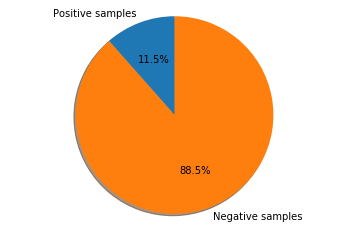

In [5]:
labels = 'Positive samples', 'Negative samples'
sizes = [g_pos_total, g_neg_total]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [6]:
def binarize_data(source):
    headers = ['age_young', 'age_adult', 'age_old',
               'marital_single', 'marital_married', 'marital_divorced',
               'education_primary', 'education_secondary', 'education_tertiary',
               'default', 'housing', 'loan', 'balance',
               'campaign_lower', 'previous_lower', 'pdays_lower',
               'suscribed']

    balance_lower_bound = 0
    campaign_lower_bound = 4
    previous_lower_bound = 4
    pdays_lower_bound = 100
    bin_data = []
    
    log_chunks = 1000

    i = 0
    for df in pd.read_csv(source, sep=',', header = 0, chunksize=1):
        if (i % 1000 == 0):
            print("Computed %d rows..." % (i))

        if (df['education'][i] == 'unknown'):
            pass

        row = []

        age = int(df['age'][i])
        row += [age < 27, age >= 27 and age <= 65, age > 65]
        row += [df['marital'][i] == 'single', df['marital'][i] == 'married', df['marital'][i] == 'divorced']
        row += [df['education'][i] == 'primary', df['education'][i] == 'secondary', df['education'][i] == 'tertiary']
        row += [df['default'][i] == 'yes']
        row += [df['housing'][i] == 'yes']
        row += [df['loan'][i] == 'yes']
        row += [int(df['balance'][i]) > 0]
        row += [int(df['campaign'][i]) < campaign_lower_bound]
        row += [int(df['previous'][i]) < previous_lower_bound]
        row += [int(df['pdays'][i]) < pdays_lower_bound]
        row += [df['y'][i] == 'yes']

        bin_data.append(row)
        i += 1
    
    print("Computed %d rows..." % (i))

    return [headers, bin_data]

In [7]:
headers, bin_data = binarize_data(source)

df = pd.DataFrame(bin_data, columns=headers)
df.to_csv(data_path + '/' + bin_data_file, index=False)

Computed 0 rows...
Computed 1000 rows...
Computed 2000 rows...
Computed 3000 rows...
Computed 4000 rows...
Computed 4521 rows...


In [8]:
def k_fold_cross_validation(X, K, randomise = False):
    """
    Generates K (training, validation) pairs from the items in X.

    Each pair is a partition of X, where validation is an iterable
    of length len(X)/K. So each training iterable is of length (K-1)*len(X)/K.

    If randomise is true, a copy of X is shuffled before partitioning,
    otherwise its order is preserved in training and validation.
    """
    if randomise:
        X = list(X)
        shuffle(X)

    if K == 1:
        training = [x for i, x in enumerate(X) if i % 3 != 0]
        validation = [x for i, x in enumerate(X) if i % 3 == 0]
        yield training, validation, 0
    else:
        for k in range(K + 1):
            training = [x for i, x in enumerate(X) if i % K != k]
            validation = [x for i, x in enumerate(X) if i % K == k]
            yield training, validation, k

In [9]:
# Generate training and verification data
with open(data_path + '/' + bin_data_file, 'r') as data:
    data.readline() # Skip first line of headers
    for training, validation, k in k_fold_cross_validation(data.readlines(), K = n_sets, randomise = True):  
        print("Generating %d/%d file" % (k + 1, n_sets))
        tf = open("%s/train_%d.csv" % (data_path, k), 'w')
        tf.writelines(training)
        tv = open("%s/test_%d.csv" % (data_path, k), 'w')
        tv.writelines(validation)
        tf.close()
        tv.close()

Generating 1/1 file


In [10]:
def parse_file(name):
    df = pd.read_csv(name, sep=',', header=None)
    y = np.array(df[df.columns[-1]])
    del df[df.columns[-1]]
    return [np.array(df).astype(int), y]

In [11]:
def count_classes(X_train):
    # Count how many positive and negative classes there are
    count_pos = 0
    count_neg = 0

    for g in X_train:
        g_class = bool(g[-1])
        count_pos += int(g_class)
        count_neg += int(not g_class)
    
    return [count_pos, count_neg]

In [12]:
def compare(obj1, obj2):
    tup = list(zip(obj1, obj2))
    intersect = []
    for i in range(len(tup)):
        if tup[i][0] == tup[i][1]:
            intersect.append((i, tup[i][0]))
    return tuple(intersect)

def calculate_hypothesis_and_add(intersect, hypotheses, context_plus, context_minus):
    total_positive_cases = 0.00;
    total_negative_cases = 0.00;

    for i in context_plus:
        if is_intersect_subset(intersect, i):
            total_positive_cases += 1

    for i in context_minus:
        if is_intersect_subset(intersect, i):
            total_negative_cases += 1

    pos_support = total_positive_cases / len(context_plus)
    neg_support = total_negative_cases / len(context_minus)
    hypotheses[intersect] = (pos_support, neg_support)

    return hypotheses

# Loop over all items in intersect and see if they are in list.
def is_intersect_subset(intersect, list):
    for i in range(len(intersect)):
        index = intersect[i][0]
        value = intersect[i][1]
        if list[index] != value:
            return False
    return True

In [17]:
'''
For each object from G+ you have to calculate intersection with the description of the object to classify 
(g'); and check, whether this description is presented in any example from G- do the same thing vice versa for G-: 
for each object description from G- calculate intersection and check whether this intersection is common with any 
object description from G+.
'''
def compute_hypotheses(context_plus, context_minus, example, example_result, hypotheses):
    for j in context_plus:
        intersect = compare(example, j)
        if intersect not in hypotheses.keys():
            hypotheses = calculate_hypothesis_and_add(intersect, hypotheses, context_plus, context_minus)

    for k in context_minus:
        intersect = compare(example, k)
        if intersect not in hypotheses.keys():
            hypotheses = calculate_hypothesis_and_add(intersect, hypotheses, context_plus, context_minus)

In [18]:
def classify_element(hypotheses, unknown, y_pred):
    score = 0
    for tuples, h_sup in hypotheses.items():
        if not match_hypothesis(tuples, unknown):
            continue

        if (h_sup[0] > h_sup[1]):
            score += 1
        else:
            score -= 1

    # Add the predicted class
    y_pred.append(score > 0)
    
    return y_pred

def match_hypothesis(tuples, unknown):
    for x in tuples:
        if x[1] != unknown[x[0]]:
            return False
    return True

In [19]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

def compute_stats(y_real, y_pred):
    stats = []

    y_real = np.array(y_real)
    y_pred = np.array(y_pred)

    TP = np.sum(y_real & y_pred)
    TN = np.sum((y_real + y_pred) == 0)
    FP = np.sum((y_real  == 0) * (y_pred == 1))
    FN = np.sum((y_real  == 1) * (y_pred == 0))

    TPR = int(TP) / np.sum(y_real == 1)
    TNR = int(TN) / np.sum(y_real == 0)
    FPR = int(FP) / (FP + TN)
    FNR = int(FN) / (FN + TP)
    NPV = int(TN) / (TN + FN)
    FDR = int(FP) / (TP + FP)

    acc = accuracy_score(y_real, y_pred)
    prec = precision_score(y_real, y_pred)
    rec = recall_score(y_real, y_pred)
    f1 = 2 * prec * rec / (prec + rec)

    stats = [TP,  TN,  FP,  FN,
             TPR, TNR, FPR, FNR,
             NPV, FDR, acc, prec, rec, f1]

    return stats

In [22]:
print_debug = True
i_file = 0 # Value must be in the range: 0 <= i_file < n_sets

### HYPOTHESES COMPUTATION
print('Computing set {} of {}'.format(i_file + 1, n_sets))

print('- Spliting plus and minus contexts')
train, y_train = parse_file(data_path + '/train_' + str(i_file) + '.csv')
plus  = [a for i, a in enumerate(train) if y_train[i]]
minus = [a for i, a in enumerate(train) if not y_train[i]]

test, y_test = parse_file(data_path + '/test_' + str(i_file) + '.csv')

starttime = datetime.now()
# Dictionary of Hypotheses:
# Key = list of tuples indicating the hypothesis
# Values = tuple containing positive and negative support (not normalized)
hypotheses = dict()
y_pred = []

print('- Computing hypotheses')
hi = 0
for i, elem in enumerate(test):
    hi += 1
    compute_hypotheses(plus, minus, elem, y_test[i], hypotheses)

    if print_debug:
        if hi % 100 == 0:
            print('-- Hypotheses computed: ' + str(len(hypotheses)) + ' - Remaining objects: ' + str(len(test) - i - 1))

print('Duration of Test ' + str(i) + ': ' + str(datetime.now() - starttime))
print('Total Hypotheses: ' + str(len(hypotheses)))

Computing set 1 of 1
- Spliting plus and minus contexts
- Computing hypotheses
-- Hypotheses computed: 11725
-- Hypotheses computed: 16119
-- Hypotheses computed: 18962
-- Hypotheses computed: 21221
-- Hypotheses computed: 23746
-- Hypotheses computed: 26209
-- Hypotheses computed: 27940
-- Hypotheses computed: 28977
-- Hypotheses computed: 30318
-- Hypotheses computed: 31226
-- Hypotheses computed: 33130
-- Hypotheses computed: 34252
-- Hypotheses computed: 35379
-- Hypotheses computed: 36184
-- Hypotheses computed: 37436
Duration of Test 1506: 0:05:02.725297
Total Hypotheses: 37624


In [26]:
print_debug = True

### CLASIFICATION PROCESS
print('Classifying unknown elements')
y_pred = []
for i, elem in enumerate(test):
    y_pred = classify_element(hypotheses, elem, y_pred)
    if print_debug:
        if i % 100 == 0:
            print('- Classified ' + str(i) + ' elements of ' + str(len(test)))

[
    TP,  TN,  FP,  FN,
    TPR, TNR, FPR, FNR,
    NPV, FDR, acc, prec, rec, f1] = compute_stats(y_test, y_pred)

Classifying unknown elements
- Classified 0 elements of 1507
- Classified 100 elements of 1507
- Classified 200 elements of 1507
- Classified 300 elements of 1507
- Classified 400 elements of 1507
- Classified 500 elements of 1507
- Classified 600 elements of 1507
- Classified 700 elements of 1507
- Classified 800 elements of 1507
- Classified 900 elements of 1507
- Classified 1000 elements of 1507
- Classified 1100 elements of 1507
- Classified 1200 elements of 1507
- Classified 1300 elements of 1507
- Classified 1400 elements of 1507
- Classified 1500 elements of 1507


In [27]:
### STATISTICS
print("True Positive: {}\nTrue Negative: {}\nFalse Positive: {}\nFalse Negative: {}\n\
True Positive Rate: {}\nTrue Negative Rate: {}\nFalse Positive Rate: {}\nFalse Negative Rate: {}\n\
Negative Predictive Value: {}\nFalse Discovery Rate: {}\nAccuracy: {}\nPrecision: {}\n\
Recall: {}\nF1: {}".format(TP,  TN,  FP,  FN,
                           TPR, TNR, FPR, FNR,
                           NPV, FDR, acc, prec, rec, f1))

True Positive: 85
True Negative: 942
False Positive: 390
False Negative: 90
True Positive Rate: 0.4857142857142857
True Negative Rate: 0.7072072072072072
False Positive Rate: 0.2927927927927928
False Negative Rate: 0.5142857142857142
Negative Predictive Value: 0.9127906976744186
False Discovery Rate: 0.8210526315789474
Accuracy: 0.681486396814864
Precision: 0.17894736842105263
Recall: 0.4857142857142857
F1: 0.26153846153846155
